In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
import math

# Load info

In [2]:
T = 0.71
M = 7
RHO = 0.844
equilibrium_time = 0


label =  f'T{T}_N{M}_RHO{RHO}'

N = 4*(M**3)
L = (N / RHO) ** (1/3)

In [3]:
data = pd.read_csv(f'../output_files/{label}/{label}_velocities_data.txt', sep=' ', names=['particle', 'time', 'VelocityX', 'VelocityY', 'VelocityZ'])

In [4]:
data.time.unique()

array([1.00000e-02, 1.50000e-02, 2.00000e-02, ..., 1.99997e+03,
       1.99998e+03, 1.99999e+03])

In [5]:
data__ = data[data.time > 1900].copy()

In [80]:
del data

In [9]:
equilibrium_time = 0
max_lag = 100
loops = 150

data__.sort_values(by=['particle', 'time'], inplace=True)

final_vacf = np.zeros(max_lag)
for initialTime in range(loops):
    data_ = data__[data__['time'] >= equilibrium_time + initialTime]

    grouped = data_.groupby('particle')

    # Initialize array to store VACF for each particle
    vacf_values = np.zeros((len(grouped), max_lag))
    for idx, (particle_id, group) in enumerate(grouped):
        velocities = group[['VelocityX', 'VelocityY', 'VelocityZ']].to_numpy()
        for lag in range(min(len(velocities), max_lag)):
            # Calculate the VACF only up to the number of available steps
            vacf_values[idx, lag] = np.dot(velocities[0], velocities[lag])

    # Compute the mean VACF for this initial time, normalized by the VACF at lag 0
    mean_vacf = np.nanmean(vacf_values, axis=0)
    mean_vacf /= mean_vacf[0]

    final_vacf += mean_vacf

final_vacf /= loops
vacf_df = pd.DataFrame({'time_lag': np.arange(max_lag), 'vacf': final_vacf})

In [10]:
df_ = pd.DataFrame({'time_lag' : np.arange(min(vacf_df.time_lag.tolist()), max(vacf_df.time_lag.tolist()), 0.5)}).merge(vacf_df, how='left', on='time_lag')
df_['vacf_'] = df_['vacf'].interpolate(method='cubic')
df_.to_csv(f'../output_files/{label}/{label}_VAF.csv', index=False)

/tmp/ipykernel_3751/150455453.py:1: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df_ = pd.DataFrame({'time_lag' : np.arange(min(vacf_df.time_lag.tolist()), max(vacf_df.time_lag.tolist()), 0.5)}).merge(vacf_df, how='left', on='time_lag')


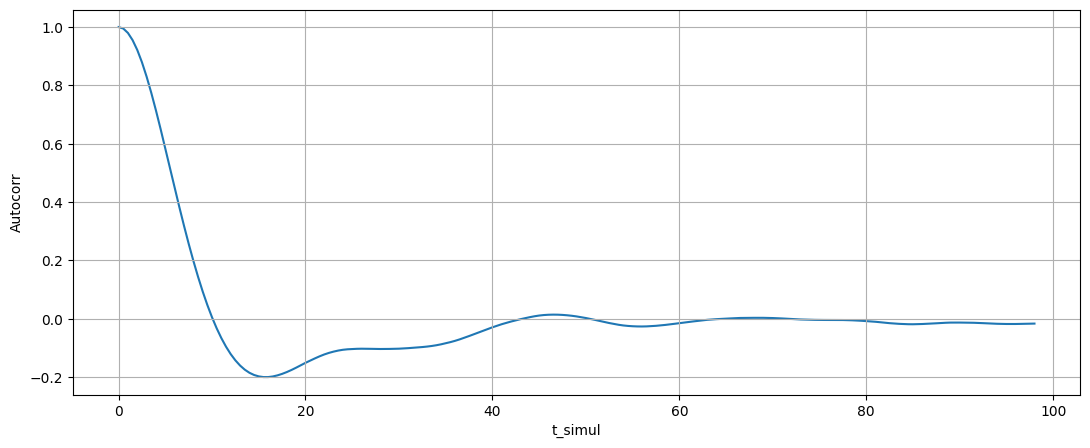

In [11]:
plt.figure(figsize=(13, 5))  

plt.xlabel('t_simul')
plt.ylabel('Autocorr')

plt.plot(df_.time_lag, df_.vacf_, zorder = 0) 

plt.grid()

1
0.7
0.5


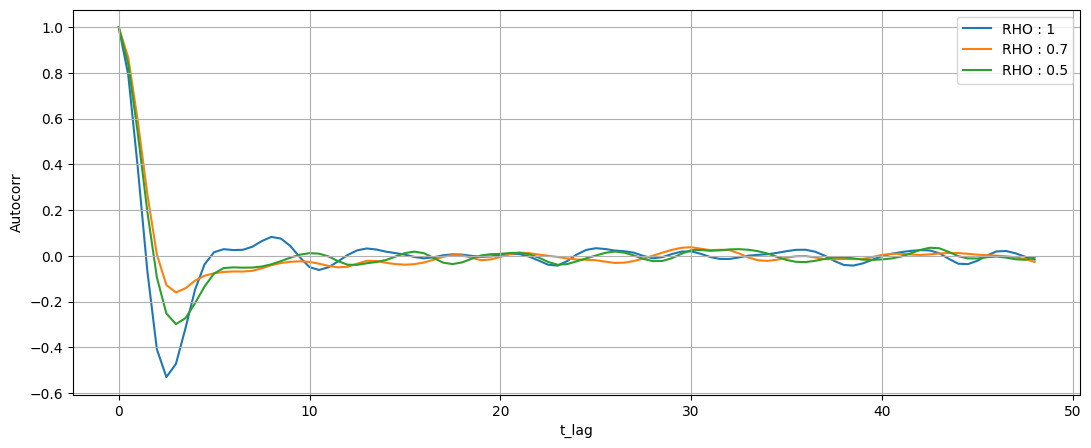

In [86]:
plt.figure(figsize=(13, 5))  

densities = [1, 0.5, 0.7]
for density in densities:
    print(density)
    label =  f'T{T}_N{M}_RHO{density}'
    df_ = pd.read_csv(f'../output_files/{label}/{label}_VAF.csv')
    plt.plot(df_.time_lag, df_.vacf_, zorder = 0, label=f'RHO : {density}') 

plt.xlabel('t_lag')
plt.ylabel('Autocorr')
plt.legend()
plt.grid()
